In [3]:
#importing neccessary libraries

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator #for data augmentation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [4]:
# loading mnist dataset.
from tensorflow.keras.datasets import mnist
(X_train, y_train) , (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


## Pre-processing of data

To use the pre-trained model and use it efficiently I have to do the following things:

Firstly,
* To extract maximum features and gain maximum accuracy we used a 3 channel image in the model trained in part1. Since, I have to use the pre-trained model, I have to change the images of MNIST to  3 channel images. I am doing so by changing it's shape from 28x28x1 to 28x28x3 by simply replicating the same pixel values.

Secondly,
* The images given in part 1 were substantially bigger(1200x700) than the size of images in the MNIST dataset(28x28). In the model created for part 1, if we would have created a deep neural network keeping the same image size of (1200x700), then we would have faced difficulty while re-training the model on (28x28) images. This is because subsequent layers of convolution and max pooling would make the 28x28 images very small and therefore leading to a negative dimension error.

* If we would have resized the images in part 1 to 28x28 then the nueral network might not have been able to extract features efficiently as scaling down them would compress pixels nearer to each other. This would have made the model weaker as it would have been hard to distinguish between classes like 1 and l, 0 and a etc.

* Thus, to achieve optimal performance we would have to create a balance between the input sizes of the images and the depth of the neural network.

* Therefore, I chose to pad the MNIST images and increase their shape from 28x28 to 40x40.

In [5]:
# concatinating train and test data so that we can apply the neccessary transformations
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

In [11]:
# changing the shape by repeating the pixel values
X = X.reshape((70000, 28, 28, 1))
X = X.repeat(3, -1)  # repeating the last (-1) dimension three times

(28, 28, 3)


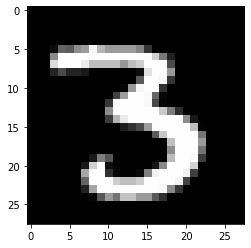

In [12]:
# sanity check
import matplotlib.pyplot as plt
plt.imshow(X[12])
print(X[12].shape)

In [3]:
# Function to pad pad images. Takes the image array of size 28*28 as the input and returns a numpy array of size 40x40. 
# The images are padded with black pixels.

# Taken from: https://www.geeksforgeeks.org/add-padding-to-the-image-with-python-pillow/
from PIL import Image
def pad_black(img):
    
    img = Image.fromarray(img)
    width, height = img.size

    right = 6
    left = 6
    top = 6
    bottom = 6

    new_width = width + right + left
    new_height = height + top + bottom

    result = Image.new(img.mode, (new_width, new_height), (0, 0, 0))

    result.paste(img, (left, top))
    

    new_np = np.array(result)    
    return new_np

Since, we cannot directly change the values in a numpy array using indexing,I have changed it to list for applying neccessary operations and then converted it back to an numpy array.

In [16]:
X_list = list(X)
for i in range(len(X_list)):
    X_list[i]= pad_black(X_list[i])
    
X = np.array(X_list)
print(X.shape)

In [14]:
# splitting the data to the standard split of 60k images in training set and 10k images in testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 10000)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 40, 40, 3)
(10000, 40, 40, 3)
(60000,)
(10000,)


In [ ]:
# Normalizing the input 
X_train= X_train.reshape(X_train.shape[0], 40, 40, 3)
X_train = X_train.astype('float32')
X_train/=255
X_test = X_test.reshape(X_test.shape[0],40,40,3)
X_test = X_test.astype('float32')
X_test/=255
print(X_train.shape)
print(X_test.shape)

## -------------------- End of preprocessing --------------------

In [15]:
# creating classes
from  keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test= np_utils.to_categorical(y_test)

(60000, 40, 40, 3)
(10000, 40, 40, 3)


In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 40, 40, 3)
(60000, 10)
(10000, 40, 40, 3)
(10000, 10)


In [17]:
# loading pre-trained model
from tensorflow.keras.models import load_model
part1_model = load_model('../input/part1-model-v2/part1_model')

In [18]:
part1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 256)       1

The pre-trained model is not an end-to-end convolution network and it also has a different input shape. To tackle these issues I have made the following modifications:
* I had already taken care of the input by converting it into a 3 channel image. 
* I had used some dense layers in the last part of my pre-trained model. Since the shape of input images is diffirent, the same layers cannot be used for the mnist dataset as the input shape to the dense layer changes. The input to the dense layer in the pre-trained model was (None,200704), whereas the input to the dense layers for the current images of size (40x40) is (None, 1024). This difference in shapes leads to an error. Therefore, I have removed the dense layers of the pre-trained model and added a new dense layers with similar units.


In [5]:
# printing the layers to check for the index of dense layers
for layer in part1_model.layers:
    print(layer)

NameError: name 'part1_model' is not defined

In [4]:
# initializing the model and the modified input layer to the model
model = Sequential()
model.add(Input(shape=(40,40,3)))

# adding the conv layers of the pre-trained model
for layer in part1_model.layers[0:-4]:
    model.add(layer)

# flattening the input from conv layers and adding the dense layers with similar units
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation = 'softmax'))     

model.summary()

NameError: name 'Sequential' is not defined

In [21]:
# callback for dynamically changing the learning rate of the model based on the validation loss.
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

#compiling the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# creating the checkpoint
checkpoint_filepath = '/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
                                            filepath=checkpoint_filepath,
                                            save_weights_only=False,
                                            monitor='accuracy',
                                            mode='max',
                                            save_best_only=True
                                            )

# training the model
hist = model.fit(X_train, y_train,batch_size=32, epochs=10, callbacks=[reduce_lr],validation_data = (X_test,y_test))

Epoch 1/10
1875/1875 [==============================] - 117s 62ms/step - loss: 0.4528 - accuracy: 0.8427 - val_loss: 0.0771 - val_accuracy: 0.9762
Epoch 2/10
1875/1875 [==============================] - 116s 62ms/step - loss: 0.0797 - accuracy: 0.9755 - val_loss: 0.0513 - val_accuracy: 0.9844
Epoch 3/10
1875/1875 [==============================] - 117s 62ms/step - loss: 0.0586 - accuracy: 0.9822 - val_loss: 0.0435 - val_accuracy: 0.9848
Epoch 4/10
1875/1875 [==============================] - 116s 62ms/step - loss: 0.0519 - accuracy: 0.9846 - val_loss: 0.0397 - val_accuracy: 0.9884
Epoch 5/10
1875/1875 [==============================] - 116s 62ms/step - loss: 0.0483 - accuracy: 0.9849 - val_loss: 0.0432 - val_accuracy: 0.9870
Epoch 6/10
1875/1875 [==============================] - 116s 62ms/step - loss: 0.0430 - accuracy: 0.9870 - val_loss: 0.0357 - val_accuracy: 0.9899
Epoch 7/10
1875/1875 [==============================] - 117s 63ms/step - loss: 0.0393 - accuracy: 0.9878 - val_loss: 0

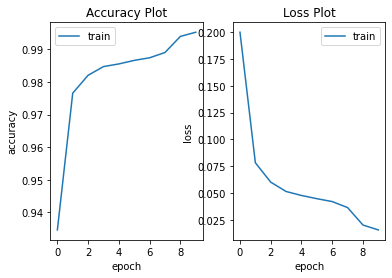

In [22]:
# plotting the loss and accuracy of the model.
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.title("Accuracy Plot")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'])

plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.title("Loss Plot")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'])

plt.show()

In [23]:
score = model.evaluate(X_test, y_test)
print("Testing loss : ", score[0])
print("Testing accuracy : ", score[1])

313/313 [==============================] - 5s 17ms/step - loss: 0.0243 - accuracy: 0.9931
Testing loss :  0.02430918999016285
Testing accuracy :  0.9930999875068665


In [24]:
# saving the model for using it in part 3
model.save('./part2_model')

In [25]:
# zipping all the output files in the kaggle working directory
!tar -zcvf outputname.tar.gz /kaggle/working

tar: Removing leading `/' from member names
/kaggle/working/
/kaggle/working/part2_model/
/kaggle/working/part2_model/assets/
/kaggle/working/part2_model/variables/
/kaggle/working/part2_model/variables/variables.index
/kaggle/working/part2_model/variables/variables.data-00000-of-00001
/kaggle/working/part2_model/saved_model.pb
/kaggle/working/__notebook_source__.ipynb
tar: /kaggle/working: file changed as we read it


Training the images on a randomly initialized model. 
To make the random model comparable to the pre-trained model I have used the similar architecture. 
The only difference is that the convoltion layers in the previous models have been initialised with the pre-trained weights whereas the random model will be initiliazed with random parameters at the start. 

In [20]:
# initializing the model
random_model = Sequential()

# layer 1
random_model.add(Conv2D(filters = 64, kernel_size = (5, 5), strides = 1, activation = 'relu', input_shape = (40, 40, 3)))
# layer 2
random_model.add(MaxPool2D(pool_size = (3, 3)))
random_model.add(Dropout(0.2))

# layer 3
random_model.add(Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, activation = 'relu'))

# layer 4
random_model.add(MaxPool2D(pool_size = (2, 2)))
random_model.add(Dropout(0.2))

# layer 5
random_model.add(Conv2D(filters = 256, kernel_size = (2, 2), strides = 1, activation = 'relu'))
# layer 6
random_model.add(MaxPool2D(pool_size = (2, 2)))
random_model.add(Dropout(0.2))

# layer 7
random_model.add(Flatten())

# layer 8
random_model.add(Dense(512, activation='relu'))

# layer 9
random_model.add(Dense(256, activation='relu'))

# layer 10
random_model.add(Dense(128, activation='relu'))

# ouput layer
random_model.add(Dense(10, activation = 'softmax')) 

random_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 36, 36, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         1

In [22]:
# learning rate changer
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

#compiling the model
random_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#checkpoint
random_checkpoint_filepath = '/checkpoint'
random_model_checkpoint_callback = ModelCheckpoint(
                                            filepath=random_checkpoint_filepath,
                                            save_weights_only=False,
                                            monitor='accuracy',
                                            mode='max',
                                            save_best_only=True
                                            )

# training the random model
random_hist = random_model.fit(X_train, y_train,batch_size=32, epochs=10, callbacks=[reduce_lr],validation_data = (X_test,y_test))

Epoch 1/10
1875/1875 [==============================] - 105s 56ms/step - loss: 0.4149 - accuracy: 0.8597 - val_loss: 0.0679 - val_accuracy: 0.9794
Epoch 2/10
1875/1875 [==============================] - 101s 54ms/step - loss: 0.0702 - accuracy: 0.9785 - val_loss: 0.0353 - val_accuracy: 0.9893
Epoch 3/10
1875/1875 [==============================] - 100s 53ms/step - loss: 0.0564 - accuracy: 0.9840 - val_loss: 0.0355 - val_accuracy: 0.9897
Epoch 4/10
1875/1875 [==============================] - 99s 53ms/step - loss: 0.0446 - accuracy: 0.9877 - val_loss: 0.0317 - val_accuracy: 0.9904
Epoch 5/10
1875/1875 [==============================] - 100s 53ms/step - loss: 0.0430 - accuracy: 0.9880 - val_loss: 0.0592 - val_accuracy: 0.9872
Epoch 6/10
1875/1875 [==============================] - 100s 53ms/step - loss: 0.0384 - accuracy: 0.9894 - val_loss: 0.0329 - val_accuracy: 0.9903
Epoch 7/10
1875/1875 [==============================] - 100s 53ms/step - loss: 0.0200 - accuracy: 0.9940 - val_loss: 0.

## Conclusion: